<a href="https://colab.research.google.com/github/sudhirshahu51/BBox-Label-Tool/blob/master/Captcha_cracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0 kaggle 

In [0]:
from getpass import getpass
user = getpass('Kaggle Username: ')
key = getpass('Kaggle API key: ')

import os
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

Kaggle Username: ··········
Kaggle API key: ··········


In [0]:
!kaggle datasets download  -p ./captcha genesis16/captcha-4-letter
!unzip -qq captcha/captcha-4-letter.zip -d ./captcha/ 

 85% 13.0M/15.2M [00:01<00:00, 7.58MB/s]
100% 15.2M/15.2M [00:01<00:00, 10.5MB/s]


## 1. Import required libraries

In [0]:
# I don't like warning messages too much
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import cv2
import glob
import h5py
import shutil
import itertools
import random as rn
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt


import numpy as np 
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, Lambda
from tensorflow.keras.layers import GRU, LSTM, Bidirectional
from tensorflow.keras.layers import Add, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import backend as K
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)

%matplotlib inline
%config InlineBackend.figure_format="svg"

Tensorflow version:  2.0.0-alpha0


## 2. Reproducibility isn't a requirement, it's a necessity!

In [0]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# set the seed for random number generator
rn.seed(seed)

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(seed)

## 3. Load the data

In [0]:
# path to the data directory
data_dir = Path("./captcha/captcha/")

# getting list of all images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))

Number of images found:  9955


Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)


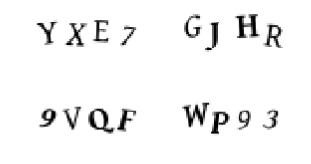

In [0]:
# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

f,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = imread(sample_images[i])
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [0]:
# make a set of all unique characters. Letter is a wrong
# word to use here but I am gonna use it for now.
letters = set()

# A list to store the max length for each catcha
lengths = []

# Iterate over each image. The name of the image is the 
# text ccontained in it. 
for image in images:
    image_name = str(image.name).split(".")[0]
    lengths.append(len(image_name))
    for ch in image_name:
        letters.add(ch)

# Sort the letters        
letters = sorted(letters)
print("Number of unqiue letters in the whole dataset: ", len(letters))
print("Maximum length of any captcha: ", max(Counter(lengths).keys()))
print("\nAll letters to be considered: ")
print(letters)

Number of unqiue letters in the whole dataset:  32
Maximum length of any captcha:  4

All letters to be considered: 
['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [0]:
dataset = []

for image in images:
    image_path = str(image)
    label = str(image.name).split(".")[0]
    dataset.append((image_path, label))

dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)
dataset = dataset.sample(frac=1.).reset_index(drop=True)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head(10)

Total number of samples in the dataset:  9955


,img_path,label
0,captcha/captcha/ED7B.png,ED7B
1,captcha/captcha/DYRA.png,DYRA
2,captcha/captcha/3976.png,3976
3,captcha/captcha/EJ6H.png,EJ6H
4,captcha/captcha/DR2G.png,DR2G
5,captcha/captcha/8TBS.png,8TBS
6,captcha/captcha/6PZZ.png,6PZZ
7,captcha/captcha/J5Z4.png,J5Z4
8,captcha/captcha/SA45.png,SA45
9,captcha/captcha/NHZ4.png,NHZ4


## 4. Separate out training and validation datasets

In [0]:
# split into train and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  8959
Number of validation samples:  996


## 5. Some helper functions

In [0]:
# function to create labels from text
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

# function to convert labels back to texts
def labels_to_text(label):
    return ''.join(list(map(lambda x: letters[int(x)], label)))

# sanity-check for letters
def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

## 6. Build the data

In [0]:
def build_data(df, resize=True, img_height=24, img_width=72):
    """This function reads samples from a dataframe and store
    the image values and labels in two separate arrays.
    
    Args:
        df        : dataframe from which we want to read the data
        resize    : whether to resize images or not
        img_weidth: width of images to be considered
        img_height: height of images to be considered
        
    Returns:
        images    : numpy array of images
        labels    : numpy array of encoded labels
    """
    n = len(df)
    images = np.zeros((n, img_height, img_width), dtype=np.float32)
    labels = [0]*n
    for i in range(n):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize:
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # only add to if all the charaters are valid
        if is_valid_str(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [0]:
# Building training data
training_images, training_labels = build_data(training_data)
print("Number of training images: ", training_images.shape)
print("Number of training labels: ", training_labels.shape)

Number of training images:  (8959, 24, 72)
Number of training labels:  (8959,)


In [0]:
# Building validation data
validation_images, validation_labels = build_data(validation_data)
print("Number of validation images: ", validation_images.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of validation images:  (996, 24, 72)
Number of validation labels:  (996,)


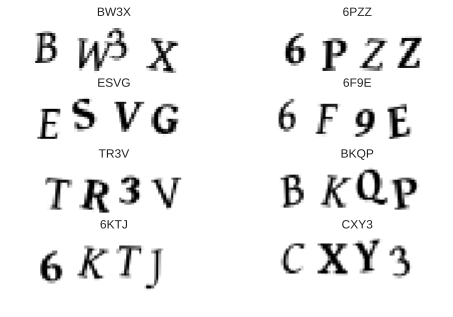

In [0]:
# Check some samples again
f,ax = plt.subplots(4,2, figsize=(8,5))
for i in range(4):
    ax[i//2, i%2].imshow(training_images[i], cmap='gray')
    ax[i//2, i%2].set_title(training_labels[i])
    ax[i//2, i%2].axis('off')

for i in range(4, 8):
    ax[i//2, i%2].imshow(validation_images[i], cmap='gray')
    ax[i//2, i%2].set_title(validation_labels[i])
    ax[i//2, i%2].axis('off')
    
plt.show()

## 7. Data Generator 

In [0]:
def data_generator(df, 
                   batch_size, 
                   img_width, 
                   img_height, 
                   downsample_factor, 
                   max_text_len, 
                   is_validation_data=False):
    """This is a data generator which yields batches 
    of (image, label) pairs.
    
    Args:
        df                : training or validation dataframe
        batch_size        : batch size ti be used during training
        img_width         : width of images to be considered  
        img_height        : height of images to be considered
        downsample_factor : by what factor the CNN has downsampled the images
        max_text_len      : maximum length of the text in your data
        is_validation_data: is the data being considered a validation data?
        
    Returns:
        inputs: numpy array containg inputs that are required for the final model
        outputs: a dummy array of zeros 
    """
    n = len(df)
    indices = np.arange(n)
    np.random.shuffle(indices)
    nb_batches = int(np.ceil(n/batch_size))
    
    if not is_validation_data:
        images, texts = training_images, training_labels
    else:
        images, texts = validation_images, validation_labels
    
    batch_images = np.ones((batch_size, img_width, img_height, 1), dtype=np.float32)
    batch_labels = np.ones((batch_size, max_text_len), dtype=np.float32)
    input_length = np.ones((batch_size, 1), dtype=np.int64) * \
                                            (img_width // downsample_factor - 2)
    label_length = np.zeros((batch_size, 1), dtype=np.int64)
    
    while True:
        for i in range(nb_batches):
            idx_to_consider = indices[i*batch_size:(i+1)*batch_size]
            
            for j, idx in enumerate(idx_to_consider):
                img = images[idx].T
                img = np.expand_dims(img, axis=-1)
                text = texts[idx]
                
                if is_valid_str(text):
                    label = text_to_labels(texts[idx])
                    batch_images[j] = img
                    batch_labels[j] = label
                    label_length[j] = len(text)

            inputs = {
            'input_data': batch_images,
            'input_label': batch_labels,
            'input_length': input_length,
            'label_length': label_length,
            }
            
            outputs = {'ctc_loss': np.zeros([batch_size], dtype=np.float32)}
            yield inputs, outputs

In [0]:
# batch size to be used for training
batch_size = 32

# image dimensions
img_width=72
img_height=24 

# by what factor the image has been downsampled by the CNN part?
downsample_factor=4

# maximum length of any text in the data
max_text_len=4

In [0]:
# Get a generator object for the training data
train_data_generator = data_generator(training_data, 
                                      batch_size=batch_size, 
                                      img_width=img_width, 
                                      img_height=img_height, 
                                      downsample_factor=downsample_factor, 
                                      max_text_len=max_text_len, 
                                      is_validation_data=False)

# Get a generator object for the validation data 
valid_data_generator = data_generator(validation_data, 
                                      batch_size=batch_size, 
                                      img_width=img_width, 
                                      img_height=img_height, 
                                      downsample_factor=downsample_factor, 
                                      max_text_len=max_text_len, 
                                      is_validation_data=True)

In [0]:
# A handy-dandy function for checking the generator output
# always sanity-check your data before passing it to the model
def visualize_data_gen_output(data_gen, samples_to_visualize=2):
    for i, (inp, out) in enumerate(data_gen):
        print('Text generator output (data which will be fed into the neutral network):')
        print('1)the_input (image)')
        img = (inp['input_data'][i, :, :, 0]*255).astype(np.uint8)
        plt.imshow(img.T, cmap='gray')
        plt.show()
        print(f"2) the_labels(captcha) {labels_to_text(inp['input_label'][i])} is encoded as {list(map(int, inp['input_label'][i]))}") 
        print(f"3) input_length (width of image that is fed to the network after CNN): {inp['input_length'][i][0]} == (72/4 - 2)")
        print(f"4) label_length (length of captcha): {inp['label_length'][i][0]}")
        print(" ")
        if i==samples_to_visualize:
            break

Text generator output (data which will be fed into the neutral network):
1)the_input (image)


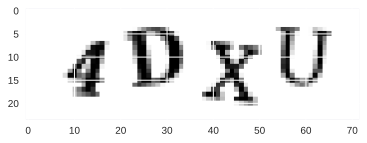

2) the_labels(captcha) 4DXU is encoded as [2, 11, 29, 26]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


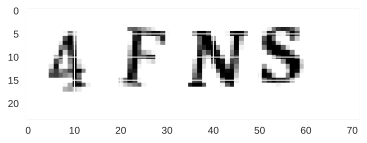

2) the_labels(captcha) 4FNS is encoded as [2, 13, 20, 24]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


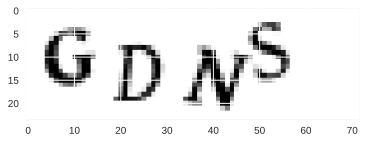

2) the_labels(captcha) GDNS is encoded as [14, 11, 20, 24]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 


In [0]:
visualize_data_gen_output(train_data_generator)

Text generator output (data which will be fed into the neutral network):
1)the_input (image)


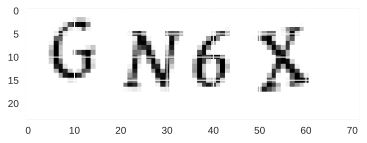

2) the_labels(captcha) GN6X is encoded as [14, 20, 4, 29]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


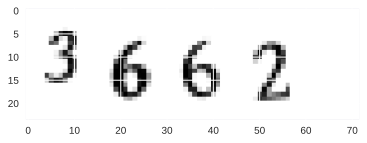

2) the_labels(captcha) 3662 is encoded as [1, 4, 4, 0]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


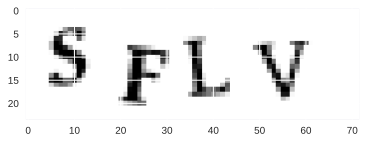

2) the_labels(captcha) SFLV is encoded as [24, 13, 18, 27]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 


In [0]:
visualize_data_gen_output(valid_data_generator)

## 8. CTC loss function

In [0]:
# We will be using this loss function as the output
# The loss function in model.compile(..) will be a dummy one
# This is different from a normal scenario where you pass an actual 
# loss function when you compile the model
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

## 9. Model

In [0]:
def build_model():
    # Inputs to the model
    input_img = Input(shape=(img_width, img_height, 1), name='input_data', dtype='float32')
    labels = Input(name='input_label', shape=[max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    # Convolution part for feaure extraction
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    # Reshape the features for passing to RNN
    # We have used two max pool with pool size and strides of 2. Hence, downsampled is 4x smaller
    # Also, the number of filters in the last layer is 64.
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = Reshape(target_shape=new_shape, name='reshape')(x)
    x = Dense(64, activation='relu', name='dense1')(x)
    
    # RNNs
    x = Bidirectional(LSTM(128, return_sequences=True,  name='lstm_1'), name='bi_1')(x)
    x = Bidirectional(LSTM(128, return_sequences=True,  name='lstm_2'), name='bi_2')(x)
    
    # final part
    x = Dense(len(letters)+1, activation='softmax', name='dense2', kernel_initializer='he_normal')(x)
    
    # Get the CTC loss and represent it in a layer
    output = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([x, labels, input_length, label_length])
    
    # define the final model
    model = Model([input_img, labels, input_length, label_length], output, name='ocr_model_v1')
    
    # optimizer
    sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    # this is the reason we have this ctc_loss array of zeros in our generator
    model.compile(loss={'ctc_loss': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    return model

In [0]:
model = build_model()
model.summary()

W0406 12:10:54.276456 140335417112448 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa1a2246b70>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0406 12:10:54.280559 140335417112448 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa1be51b1d0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0406 12:10:54.496226 140335417112448 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa1be476e80>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0406 12:10:54.500396 140335417112448 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa1be3aae48>: Note that this layer is not optimized for performance. Please use tf.keras.laye

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 72, 24, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 72, 24, 32)   320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 36, 12, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 36, 12, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

In [0]:
# things required for starting the training 
nb_epochs = 50
nb_train_steps = training_data.shape[0] // batch_size
nb_validation_steps = validation_data.shape[0] // batch_size
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ckpt = ModelCheckpoint(filepath='captcha_cracker.h5', save_best_only=True, monitor='val_loss')

In [0]:
# Train the model
history = model.fit_generator(train_data_generator, 
                    epochs=nb_epochs, 
                    steps_per_epoch=nb_train_steps, 
                    validation_data=valid_data_generator, 
                    validation_steps=nb_validation_steps,
                    callbacks=[es, ckpt])

Epoch 1/50
279/279 [==============================] - 32s 115ms/step - loss: 15.4873 - val_loss: 14.8236
Epoch 2/50
279/279 [==============================] - 28s 99ms/step - loss: 14.7499 - val_loss: 14.7227
Epoch 3/50
279/279 [==============================] - 27s 98ms/step - loss: 14.6860 - val_loss: 14.6653
Epoch 4/50
279/279 [==============================] - 27s 98ms/step - loss: 14.6642 - val_loss: 14.6711
Epoch 5/50
279/279 [==============================] - 27s 98ms/step - loss: 14.6430 - val_loss: 14.6751
Epoch 6/50
279/279 [==============================] - 27s 97ms/step - loss: 14.6310 - val_loss: 14.5909
Epoch 7/50
279/279 [==============================] - 27s 97ms/step - loss: 14.5352 - val_loss: 14.3965
Epoch 8/50
279/279 [==============================] - 27s 96ms/step - loss: 14.3549 - val_loss: 14.1680
Epoch 9/50
279/279 [==============================] - 27s 97ms/step - loss: 14.2173 - val_loss: 14.0072
Epoch 10/50
279/279 [==============================] - 27s 97ms

## 10. Testing the model

In [0]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, 2:]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = K.get_value(K.ctc_decode(pred, 
                                   input_length=input_len,
                                   greedy=True)[0][0])
    
    # Iterate over the results and get back the text
    texts = []
    for res in results:
        outstr = ''
        for c in res:
            if c < len(letters):
                outstr += letters[c]
        texts.append(outstr)
    
    # return final text results
    return texts

In [0]:
# Get the input output layer and define a Keras function
# It is similar to getting layers in tensorflow and 
# passing the information to the session.
output_func = K.function([model.get_layer(name='input_data').input],
                        [model.get_layer(name='dense2').output])


#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = output_func([X_data])[0]
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'GT: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

GT: RP3Y 	 Predicted: RP3Y
GT: CDSV 	 Predicted: CDSV
GT: MB5E 	 Predicted: MB5E
GT: 8CTC 	 Predicted: 8CTC
GT: EEV4 	 Predicted: EEV4
GT: DD37 	 Predicted: DD37
GT: GAAK 	 Predicted: GAAK
GT: LSYF 	 Predicted: LSYF
GT: AF78 	 Predicted: AF78
GT: HZW4 	 Predicted: HZW4
GT: JGSQ 	 Predicted: JGSQ
GT: TPUU 	 Predicted: TPUU
GT: 8E2U 	 Predicted: 8E2U
GT: AR4Z 	 Predicted: AR4Z
GT: YPSH 	 Predicted: YPSH
GT: 887X 	 Predicted: 887X
GT: MHB7 	 Predicted: MHB7
GT: R7Y8 	 Predicted: R7Y8
GT: PSG8 	 Predicted: PSG8
GT: 7YD3 	 Predicted: 7YD3
GT: F6HB 	 Predicted: F6HB
GT: A6T9 	 Predicted: A6T9
GT: 5R6J 	 Predicted: 5R6J
GT: CH5T 	 Predicted: CH5T
GT: AYE2 	 Predicted: AYE2
GT: FCCR 	 Predicted: FCCR
GT: F3Y4 	 Predicted: F3Y4
GT: HFFQ 	 Predicted: HFFQ
GT: GHZ3 	 Predicted: GHZ3
GT: Q654 	 Predicted: Q654
GT: X6UG 	 Predicted: X6UG
GT: NWPH 	 Predicted: NWPH
